In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import abspath

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
# Read in the 5-year data from the MSFT stock
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), header=0, index_col='Date', parse_dates=True)

df.columns.name = df.index.name
df.index.name = None

# Keep nothing but the date and the opening price in the df
df = df.filter(['Date', 'Open'])

df.head()

Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


Date             Open
2017-03-01  64.129997
2017-03-02  64.690002
2017-03-03  63.990002
2017-03-06  63.970001
2017-03-07  64.190002


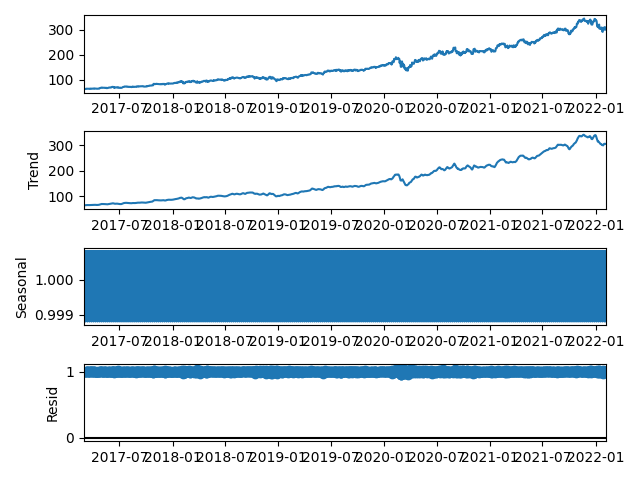

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_copy = df.copy()

print(df_copy.head())

result = seasonal_decompose(df_copy.asfreq('D', method='ffill'), model='multiplicative')
result.plot()
plt.show()

In [5]:
# Split the data into training and testing with a 75-25 split
train_size = int(len(df) * 0.975)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:]

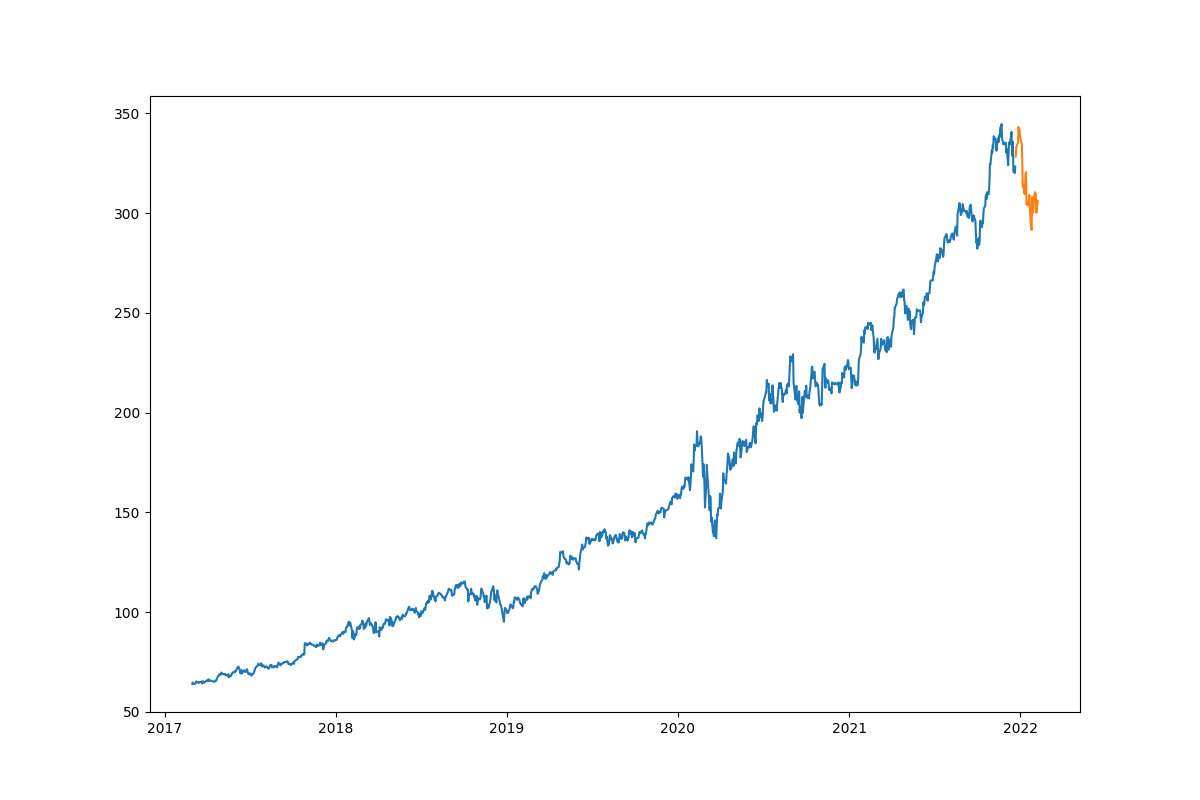

In [6]:
# Plot the training and testing data in the same figure
plt.figure(figsize=(12, 8))
plt.plot(train['Open'], label='Training Data')
plt.plot(test['Open'], label='Testing Data')

In [7]:
train.index = pd.DatetimeIndex(train.index).to_period('B')
train = train.asfreq('B')
test.index = pd.DatetimeIndex(test.index).to_period('B')
test = test.asfreq('B')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=5854.793, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=5857.989, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=5857.191, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=5856.242, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=5863.525, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=5852.990, Time=1.90 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=5851.033, Time=0.31 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=5852.981, Time=1.38 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=5849.433, Time=0.37 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=5851.011, Time=0.43 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=5851.033, Time=0.45 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=5852.795, Time=1.34 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=5847.548, Time=0.17 sec
 ARIMA(0,1,2)(1,0,0)[4] intercept   : AIC=5849.146, Time=0.29 sec
 ARIMA(0,1,2)(0,0,1)[4] intercept

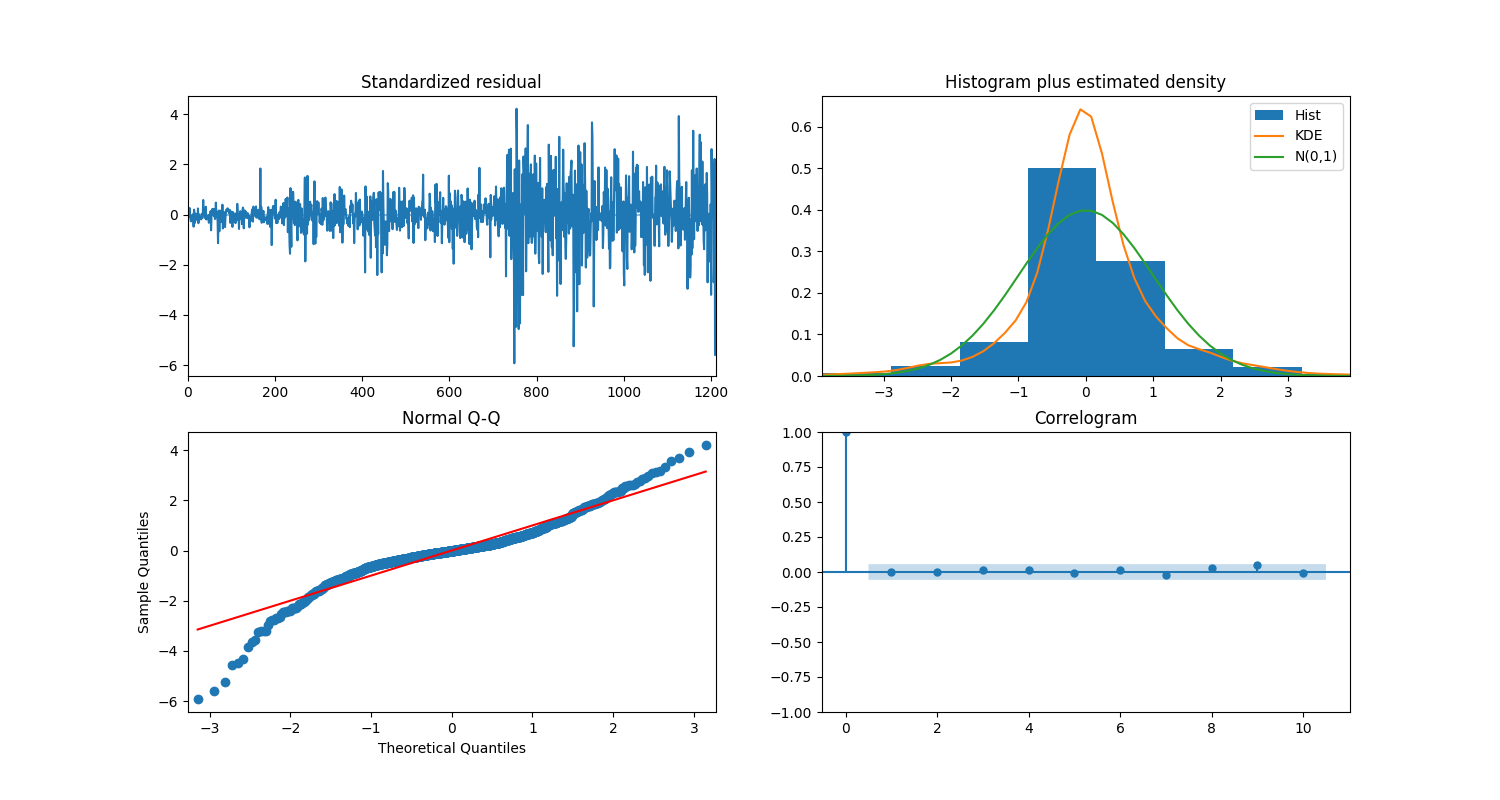

In [8]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train, 
                      test='adf',       # use adftest to find optimal 'd'
                      seasonal=True,   # No Seasonality
                      m=4,
                      trace=True,
                      error_action='raise',  
                      suppress_warnings=True, 
                      stepwise=True,
                      njobs=-1)

print(auto_model.summary())
auto_model.plot_diagnostics(figsize=(15,8))
plt.show()

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(0,1,2), seasonal_order=(0,0,0,4))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 1213
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -2924.933
Date:                Fri, 25 Feb 2022   AIC                           5855.865
Time:                        21:31:56   BIC                           5871.166
Sample:                    03-01-2017   HQIC                          5861.626
                         - 12-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0561      0.018     -3.121      0.002      -0.091      -0.021
ma.L2         -0.0765      0.020     -3.761      0.000      -0.116      -0.037
sigma2         7.3061      0.164     44.588      0.0

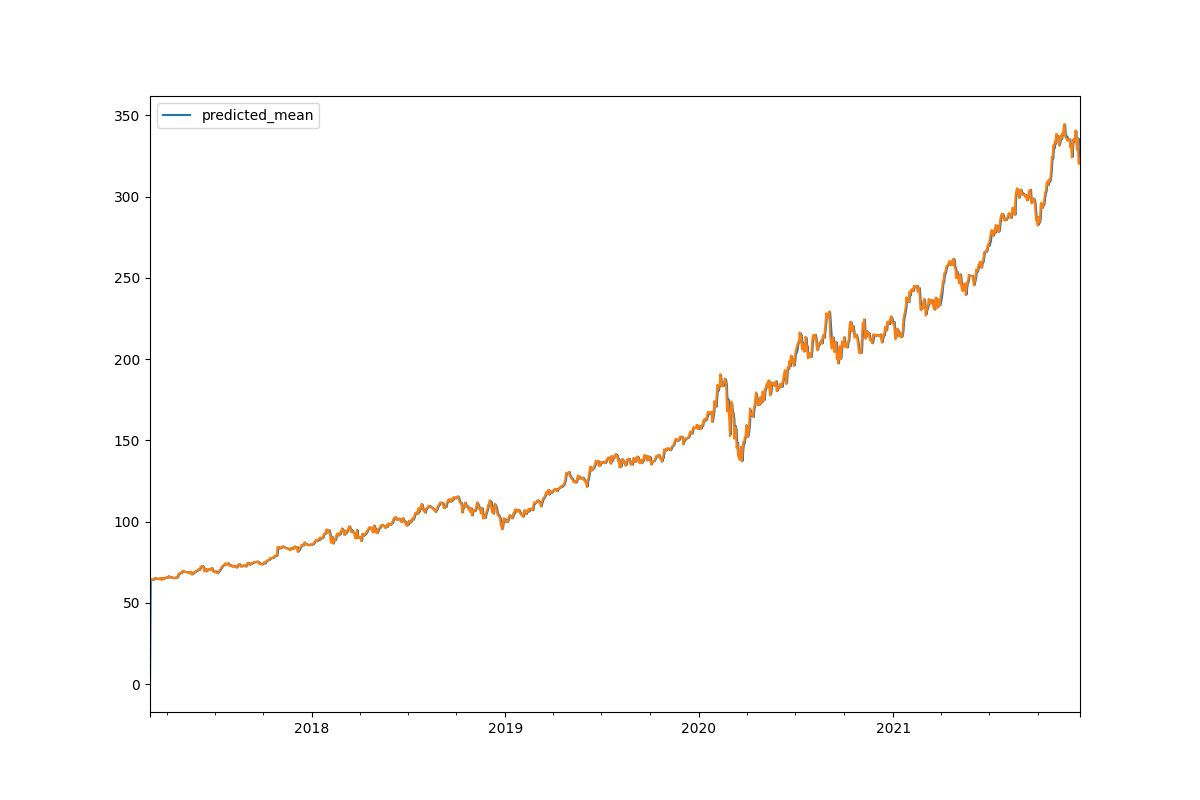

In [10]:
precast = fitted.predict()

trainingLearned = precast.to_frame()

trainingLearned.plot(label='Learned', figsize=(12,8))
plt.plot(train['Open'], label='Training Data')

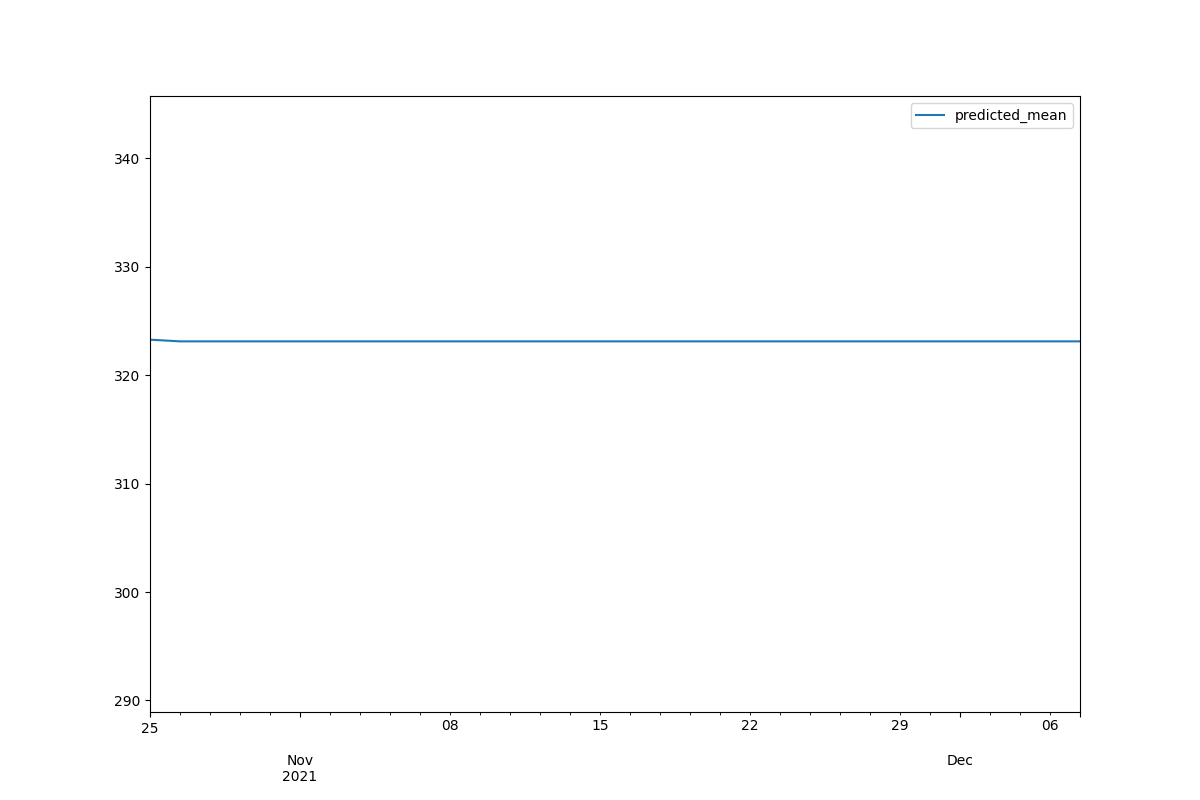

In [11]:
forecast = fitted.get_forecast(steps=test_size)

forecast_df = forecast.predicted_mean.to_frame()

# Rename the index to Date
forecast_df.index.name = 'Date'

forecast_df.columns.name = df.index.name
forecast_df.index.name = None

# Plot the forecast
forecast_df.plot(label='Forecast', figsize=(12,8))
plt.plot(test['Open'], label='Testing Data')


In [12]:
# Save the forecast_df to a csv file
forecast_df.to_csv(abspath('../../../data/MSFT/MSFT-5-Year-Forecast.csv'), index_label='Date')